27/01 Alex's code calculates the energy of the system initially, performs the swap move,
calculates the new energy of the system, then does MH algorithm to decide whether to stay or go back
this seems wildly inefficient.

Currently evaluates the energy of the entire lattice twice per iteration

Ising hamiltonian:
$$ H = -J \sum^N_{\langle i,j \rangle} S_i S_j$$
$$ S_i,S_j \in { -1,1 }$$

For site S(x,y), evaluating nearest neighbours:
$$H(x,y) = - J S_{x,y}[S_{x+1,y} + S_{x-1,y}+ S_{x,y+1}+S_{x,y-1}]$$

So summing 4 nearest neighbours for each lattice site and multiplying by site value gives each sites contribution to the energy.
We can do this using np.roll(Python) or circshift(Julia)

Sort of vectorised so more efficient (but still evaluating the energy of sites that haven't been affected by the move)


In Alex's code candidate_generating_function! is determined in run Metroplois algorithm function, deciding whether to do random swap move or slice rotation

TO DO:
Build correlation function - DONE
- why does Alex's code have two functions that do the same thing


"Generating function"
no need for inverse as each flip is binary
(assuming we don't ever produce moves that are non-commutative ie series of flips)

Autocorrelation function:

$$C(t)  = \frac{1}{N^2} \sum^{N^2}_i \delta_{\sigma_i(t), \sigma_i(0)}$$

Reversing functions successfully implemented. Will need to ensure all flip functions take the same arguments:
- reverse argument
- reversing information so if reverse true we can flip back

29/01/25
After lots of debugging I have a script that runs basic MH algorithm for various beta. Seems to converge.
Now to mess around with values to get some nice hysteresis?<br>

TO DO in future: Use previous magnetisation as starting point for next iteration?

- Additional functions added - haven't tested them out yet. Need to add manual input of which swapping function to use.
- Main challenge next is working out the workflow in terms of what data needs to be generated - great we can monte-carlo anneal but what are the interesting parameters?

30/01/25 Fig1 is average energy not magnetisation which is a bit more interesting. Adjust for graphing 1/beta ~ temperature.

Use autocorrelation run to determine number of iterations required to be uncorrelated from previous state
use these n values for subsequenet "measurements" of energy. each measurement being a series of iterations of MC.


series of temperatures logarithmically spaced

first iteration calculated n number of iterations to decorrelate between each temperature value.
once you've got these n values:

for each run cool from high temperature to low temperature, run for n values and then compute the energy
repeat this run for ~50 different runs
so we have energy as a function of temperature 50 times


profile view

10x10 initially
50 copies
100 temperature intevrals
cutoff iterations of 5000

change energy calculation

01/01/25 Realised current energy calculation doesn't generate energy difference of monte carlo move, just the absolute energy.
Also issue with calculating the energy of the entire lattice.
<br>
currently we have function that just calculates energy of lattice
and we apply move function, calculate new energy and use monte carlo to decide whether to go revert this move

however this involves calculating the energy of the entire lattice (twice) per move
instead we should just evaluate the energies that change
<br>
if we have a set of length k of flip sites
$$ { (x_1,y_1),...(x_k,y_k)}$$
then the change in energy from applying the flips is the change in energy of these sites, plus the change in energy of the neighbouring sites.
<br>
These are the same energy (maybe have been double counting before anyway?) so we just need to evaluate the "on-site energies"
<br>
Also as we're just flipping the sign of the site, the change in energy is just twice the original energy
<br>
ie if we have spin in +1 state, and has neighbours (+1,-1,+1,+1)
initial energy is  +1 * (+1 - 1 + 1 + 1) = +2
final energy is -1 * (+1 - 1 + 1 + 1) = -2


### Proposed new structure of flipping

- one single function that decides what flip move to do and generates list of flip sites

- one single function to calculate energy change of flipping
- - mask interactions between flips by setting sites to 0

- one function to do the flipping



Need to work out result of two flipping sites being adjacent whether energy change cancels out?

### In run_monte_carlo_for_beta, the same lattice object is used repeatedly accross copies of the simulation, without resetting, TO FIX

resetting is a bit more nuanced than I originally thought. solved config is obviously minimal energy configuration - might be a bit weird in terms of accessing state you wouldn't be able to access initially

similarly taking "avg" magnetisation sample isn't necessarily useful

best to start by evolving at very high temperature, maybe let beta = 0

PLAN for next session:
- implement function that prepares lattice by evolving at beta = 0
- implement the algorithm discussed in meeting:
- - start at high temperature
- - iterate until decorrelation
- - take energy measurement
- - decrease temperature slightly, repeat
- - once got energy vs temperature set, repeat again, take averages of energies

- implement the calculating decorrelation n algorithm
- -  on first temperature run, calculate the number of iteration it takes to decorrelate at each temperature
- - now when calculating energies for all the copies, no need to run decorrelation function every time


02/02/25
$$ T_i = T_0 \left[(\frac{T_N}{T_0})^{1/N}  \right] ^i $$

Interesting stuff happens at low temperatures, (high betas) so we want more values to be centered on this
$$ \beta_i = \beta_N \left[(\frac{\beta_0}{\beta_N})^{1/N}  \right] ^i


# What does (converged, current_configuration_correlation_funciton value, current_iteration, accepted_candidates) do?


## Have I got the correct energy scaling?

03/02/25
Set up working algorithm as discussed in meeting, with non-linear temperature distribution, generating measurements as cooling and then repeated to get average energies at each temperature. Still unsure about normalisationg factor for the calculating energy function. Also issue with the normalised calculated energy - surely we'd expect average energy of 0?<br>

TO DO: implement method where decorrelation ns are generated first round.

Play around with temperature range for decorrelation n.
May be the case that we can't get a useful n decorrelation


Sanity check - single spin flip, show that energy has smooth second order phase transition
shouldn't see n 

TO DO: 
- energy temperature curve for single spin flips, maybe check different sizes 
- same curve for k-chain, k-line
- reorganise code so decorrelation.jl is included in methods of lattice.jl or montecarlo.jl

next steps:
 - autocorrelation function against time
 ie cool to temperature, then start autocorrelation measurement (iterate monte carlo steps)
 will require many runs, then fit to stretched exponentials
 - plot decay times against temperature
<br>
 then:
 - obtain connectivity by exploring the possible moves of a configuration

06/02/2025
- Realised I was cooling from cold to hot. I got T_start and T_end the wrong way. replaced with T_cold and T_hot to avoid confusion.
- TO FIX: realised flipping the same spin multiple times doesn't make sense as you're still using the energy of the unflipped lattice.
<br>
- prepared files to generate energy curves
- got working correlation curves
- - upping N = 100 gives hugely smoother curve
<br>
- Fitting relaxation curves to VTM, should I take average of runs then fit or fit then take average?

07/02/2025
 - Fitting k line flip gives error of exponeniating complex parameter. Not sure we want a complex parameter fit? Tried running it again and no such issue
 - Julia keeps throwing error about filename global/local variable, should probably fix

 - Next steps: Get working functions for exploring saddle points
 - Need to work out how saddle index density is determined
 - spike in low beta suggests initially prepared incorrectly in energy anneal

## 10/02/25 Meeting summary
Compare single flip ising model to literature - specific heat, susceptibility (fluctuation dissipation theorem)

measure n decorrelation for k = 1, then use these n values for k larger than 1.
find some k' > 1

rescale autocorrelation iteration for every monte-carlo step - so every N = LxL
10,000 monte-carlo steps
will want larger N for lower noise on correlation stuff

new fit A = 1, C = 0

plot log log C
could try fitting log directly

approach low energies using k = 1, then explore saddle index using k moves

don't allow for multiple picks of the same site ie flip and unflips


11/02/25

- Single flips - do single copy runs, calculate variance in energy for each temperature, use fluctuation dissipation theorem.
- Also take the average of all single copy runs, calculate dE/dT to give heat capacity
- $$\Delta S(0\rightarrow T) = \int^T_0 \frac{C(T^{'})}{T^{'}}dT^{'}$$

- When calculating derivative, not sure if better to differentiate and then take average or vice versa?
- fluctuation and derivative results only seem to match when fluctuations multiplied by 100?
- This is due to taking the average after differentiating ^
- Still need to decide whether to take average first, or differentiate first and remember to correct by factor of m copies

12/02/25
- Ran code overnight and still no sign of finishing - serious need of optimising
- Also pressing is reframe number of "Monte Carlo iterations" as N = L^2 attempted moves
- energy_change using deepcopy not ideal as extra memory allocation?
- bitarray for lattice allocation? - probably not memory isn't an issue, more running time


- vectorisation of energy calculation and various @inline etc seem to have made some improvements.
- defeated by ProfileView - so confused
- still need to fix calculating autocorrelation every N = L^2 moves


https://warwick.ac.uk/fac/cross_fac/complexity/study/emmcs/outcomes/studentprojects/kim_m1.pdf


sort of fits onsager energy if I scale by 2/N and set J = 0.5?
entropy not a good fit

13/02/25
- Susceptiblity requires application of external field - is this something worth implementing
- Got some sort of onsager results but they don't match results obtained

- Changed generation of n decorrelation. Only measures autocorrelation function every N^2 iterations - ie 1 Monte Carlo iteration (every site on board gets a move)
- Also need to change how measurements work.
- generate_correlations function?
- things do seem to be changing significantly within '1 monte carlo timestep' so surely makes sense to measure within it?
- still yet to resolve using fluctuation dissipation theorem vs differentiating for the heat capacity

#### Plan for saddle index stuff

- Don't allow for repeated flips, need to comb through generate moves as well as explore moves.
- - Resolved for generate moves
- - 
- cool down to desired temperature/energy using single flip
- then do explore moves on cooled state to determine saddle index
- - does it make sense to do many runs of cooling, or could we decorrelate at a given temperature?
- - - probably not decorrelate as we are interested in where it gets "stuck"

#### Things that need resolving
- Onsager not matching
- Fluctuation dissipation not matching
- investigate new fit - plot loglogC?

14/02/25
- Changing when decorrelation n is calculated. As per Claudio's suggestion, calculate n_decorrelation for k = 1 ie single flip, then use these decorrelations for subsequent runs.
- therefore generate decorrelation n in figure_E_anneal before iterating through k values.
<br><br>
- will need to fix other uses of generate_energies/cocatenate_energies potentially?
- Implemented, needs testing?
- Added multipler of iterations used as a fraction of iterations taken to reach 1/e

#### BIG mistake

Autocorrelation should tend to 0.5 in the way that I've defined it.
- for an initial configuration
- if we assume system is decorrelated, each site has a 50/50 chance of matching or not.

15/0/25
- Implemented fix for autocorrelation investigation
- - Needs testing

- Onsager reference was describing "reduced free energy" which is actually beta * F = - lnZ
- - Needs testing
- - had a look, no idea how entropy can be negative
- - energies also don't seem to match
- - could be a remnant of incorrect autocorrelation function - unlikely
- - could be inconsistent calculation of energy/ input of J in onsager formula?

- TCM replied with suggestion to fix server issue
- - to attempt


17/02/25
Working server, can submit jobs to run!
TO DO:
- parallelise?
- investigate decorrelation function fix? DONE
- Clean up git: DONE
<br><br>
- Git cleaned up back to main branch, can now push from both remote and local repository
- decorrelation results generated for single spins, effect of varying N and number of monte-carlo iterations




TO DO:
- If we've generated n_correlation for 1/e cutoff, look at effect of using j * n_correlation, see if still stuck out of equilibrium
- Revisit VTM fit
- - problems with exponentation with fitting

18/02/25
- To implement maximum_iterations being scaling with N^2

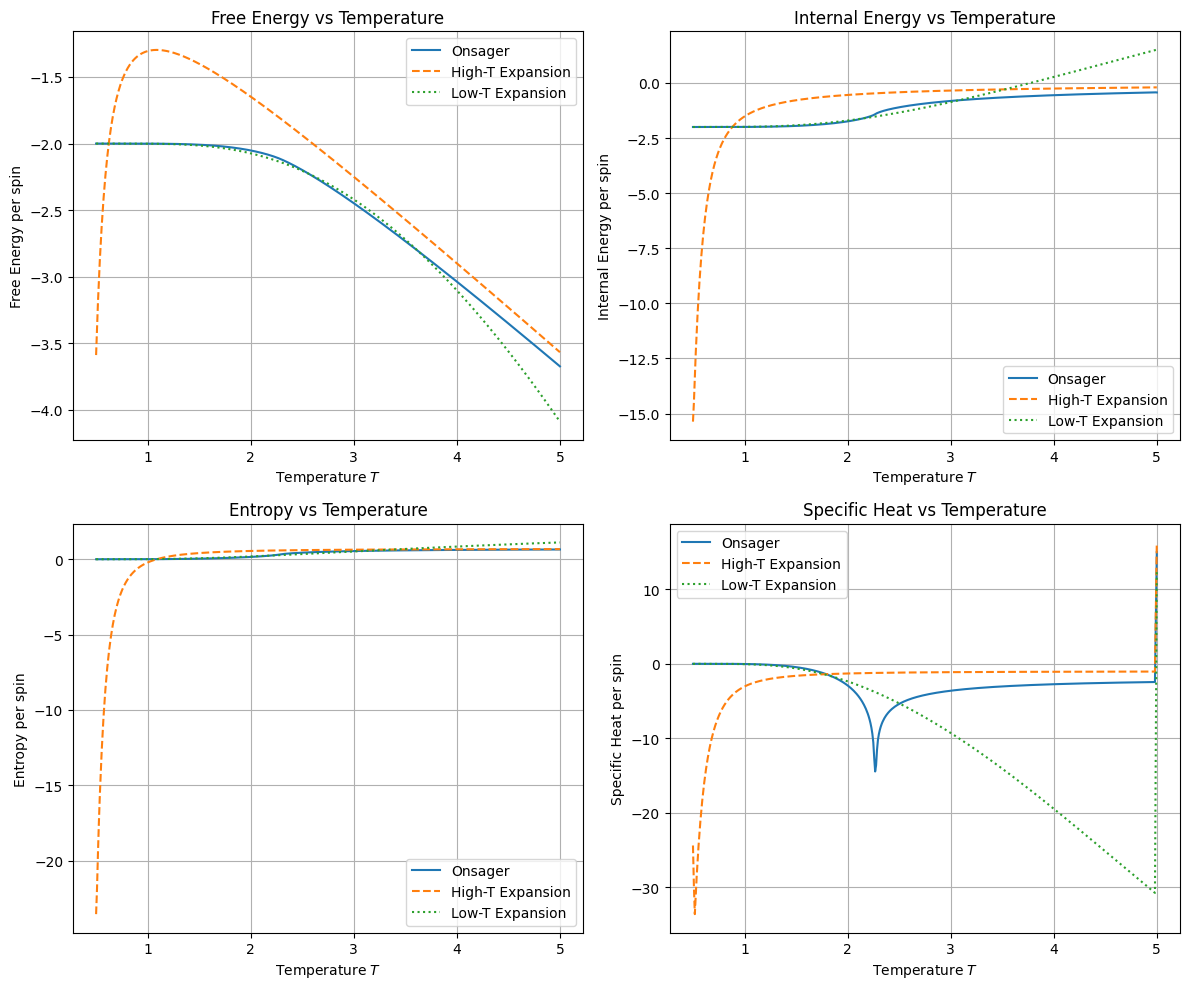

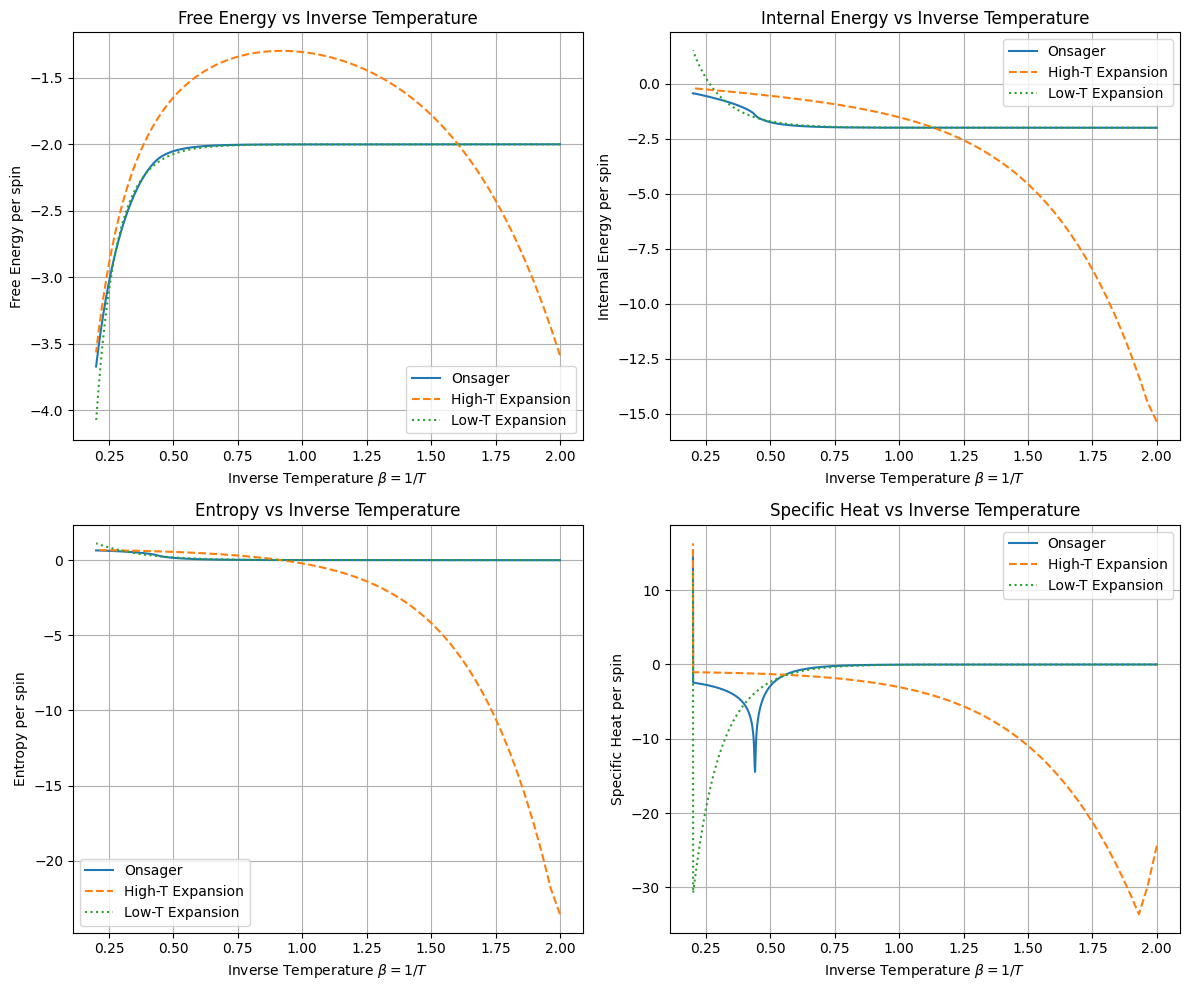

22/02/25

- saddles.jl not using number of monte carlo steps based on N, currently fixed maximum number of iterations - TO FIX
- sent off jobs for varying p, N = p N_tau for various k energy against beta. Want to show that for range of k that system stays out of equilibrium
- sent off jobs for saddles data for various k
- TO DO: frequency of saddle index instead of just average

27/02/25
- Is it ok to not sweep over each site in the lattice in 1 MC timestep, but just take L^2 random sites? Sweeping provides issues with k > 1 surely?
- Might be worth keeping running tally of energy instead of calculating energy every time we want to change it?

- Worth using cluster algorithm for critical temperatures? Probably not for k spins as different cluster?
- - Cluster: cast filled bonds probabilistically, identify all clusters of spins connected by filled bonds, flip them with p = 0.5.
- - Could you implement k spin model by only flipping if the clusters consist of a number of k moves? probably unlikely.

<br><br>
generate_correlations is still calculate autocorrelation function every single iteration.
<br><br>

Implemented new autocorrelation function. Not working clearly, cutoff immediately => initial condition with prepared lattice gives C = 0, as prepare_lattice currently does nothing.


### Autocorrelation rebuild

- defined 100 temperatures log-spaced between beta = 0.1, beta = 5. DONE, just need to adjust bounds

- Define tau_0 such that tau_0(T) =A e^(C/T), tau_0(T_max) = 10, tau_0(Tmin) = 10,000, function that returns array of tau_0 DONE

- Remove calculation of autocorrelation function in run_metropolis_algorithm entirely, it should just take an argument of max iterations. NEEDS INTEGRATING
- Create function that generates tau(T) given tau_0(T)
- - start at largest temperature:
- - - run MC for tau_0(T) MC steps = ie tau_0 * L^2 iterations
- - - record C (t)  = sum_i s(t)s(0), and m(t) = sum_i s(t) at every MC step
- - repeat for next temperature
- - gives array (t,m(t),C(t)) for each temperature
- - run ~10 times, take average for each temperature
- - calculate autocorrelation function from these averages



Things modified:
- run_metropolis_algorithm:
- - arguments
- - output parameters

- generate_decorrelation_n
- - changed name
- - changed arguments
- - changed functionality


<br><br>
- Prepare_lattice - changed to 100 MC_steps - probably overkill? could get way with 10 MC steps given they're guaranteed  to be accepted for beta = 0?

#### New approach for tau
- We will generated tau as needed and save it to a csv saved in core
- When initialising lattice, save tau_values to lattice.tau_values by reading from csv, saves effort of regenerating every time.

IMPORTANT QUESTION
- generate_energies, when we are moving from temperature to temperature, can we just use tau, or should it be more?

- deleted generate_correlations as new function generate_autocorrelation does the same job. (Used to get tau using 1/e but as it produces a times series of the autocorrelation function we could do the stretch exponential fit)

#### Need to decide what approach is for things like measuring autocorrelation function - for some of them it converges within 1 MC step - do we just need to measure more frequently?
whole stuff with VTM won't work yet then

Not convinced my current method for calculating the autocorrelation function is corect still.
Shouldn't it be <m(t) * m(0)> - <m(0)> * <m(t)>
whereas I am calculating sum over spins of the bonds

Can see autocorrelation function getting stuck at non-zero values, plateaus - this is definitely not correct.
Explains the exponential curve I was seeing - virtually all the low energy ones are just bottoming out and reaching 10*tau0

03/03/25
Using N&M autocorrelation method with energy got promising results.
Issues with spin and magnetisation as observables
- spin = unclear whether order of averaging before computing autocorrelation makes difference?
- magnetisation = average magnetisation = 0 below phase transition so issues with dividing by zero. Potentially fixed by considering absolute value of magnetisation? whether large L helps?
<br>
In general issues with dividing by variance to normalise at low temperatures as variance very small?

<br><br>
Also fixed issue when computing energy change for proposed move - factor of 2. May explain factor of 2 involved in entropy change I was having issues with previously?
TO DO: 
- tidy up workspace, reintegrate new autocorrelation function into rest of codebase.
- reintegrate logarithmically spaced temperatures
- exponentially spaced tau0? to discuss with Claudio maybe?
<br><br>
- Re run all the energy stuff with the fixed energy change - hopefully fixes the entropy problem - heat capacity half width etc


04/03/25
- Fixed bug: When looking for 1/e cutoff, previously if not found assigning to last item in autocorrelation history, this makes no sense. We want the index for a time value. 
- lattice.jl properly integrated
- montecarlo.jl all other functions just take tau_values as an argument - of how many MC steps to run at each temperature before measuring.
- moved old autocorrelation functions to bottom of page
- allow for multiple copies of generate tau?

<br><br>
- potentially fixed figure_correlation_decay = needs testing most likely


09/03/25
- Implemented spin decorrelation function. Still a bit confused how to deal with magnetisation given broken symmetry.
- Found glaring error: minus sign in energy change function was causing antiferrogmagnetic dynamics. Might explain issues with zero variance ie dividing by zero in autocorrelation function?
- Will need to rerun pretty much everything I trust already.
- Particularly single flip results.

10/03/25
I think averaging over histories is an issue due to spontaneous symmetry breaking? Once correlation length diverges, even fr


11/03/25
- implement ensemble average method of computing autocorrelation function
- doesn't seem to reach zero
- to test, could try if swapping S(0), S(t)



14/03/25
rule of thumb boltzmann factor * times MC step should be roughly greater than 1
spin ensemble getting negative values


spin autocorrelation function
average over histories

above Tc average of sigma is 0
connected and non-connected are identical


#### spin autocorrelation debugging
- Wondering if the issue is taking the average over histories over the broken symmetry state? Could we partition based on their final state?

- Identified the fact that normalising currently occurs after taking average over all spin sites. Tried normalising before average and resulted in very noisy data - autocorrelation of larger than 1?
- Potentially look at magnetisation as observable?

17/03/25
- "Smectic" striped phase seems to be messing with AC function
- Seems we can drive down temp to measure AC by increasing system size.


18/03/25
- Tried magnetisation ensemble average method, very little luck. Unclear whether need to increase number of copies in the average, whether the (pseudo) absolute value magnetisation thing was causing any issue?
- Submitted a long run for spin autocorrelation. Not hopeful the critical slowing down will be visible.

- Might be best to use energy autocorrelation with average over time?

$$ \exp(-8 \beta J) N^2 = 1$$
is the expected number of flips per MC step from the fully magnetised state, as all flips have an energy cost of 8
$$ \beta = \frac{1}{8} \ln (N^2) $$

N = 100, gives a critical temperature:
$$ \beta_{ac} = \frac{ln(N)}{4} = 1.151 $$
$$ T_{ac} = 0.8685 $$

Comparing to the critical temperature gives a minimum N ballpark for our autocorrelation measurement be useful below the phase transition:
$$ N_{ac} = \sqrt{\exp(8\beta_c)} $$
Or for N = 1000:
$$ \beta_{ac} = 1.73



24/03/25
Previous big runs for time average spin and energy corrs failed to run, have resent jobs.
Re run of single flip energy results gives negative energy. THink it might be a missing minus sign in the calculate energy bit. Will check the fit script.

<br>
Fluctation dissipation theorem method of calculating heat capacity doesn't fit below critical temperature.
<br><br>

When fitting stretched exponentials, is it okay to have a exp(-(t/tau)^alpha) + epsilon form, as actual AC fluctuates below zero which isn't physical and doesn't fit model? Also don't want to overfit
NEXT STEPS: write function to apply stretched exponential fit to all autocorrelation measurements, collate.
graph select number of fitted ACs, and obtain tau against temperature
<br><br>
Implemented functions for stretched exponential fits, obtains tau and alpha
Implemented functions that collates stretched fits for beta
Implemented function that takes fitted tau, fits VFT and plots resultant fit
VFT very poor fit for single flip - as expected not glassy
Issue of phase transition?
Data used for testing so far has just been spin correlation function close to critical temperature so not particularly instructive.
<br>
TO DO:
Set up master function that generates autcorrelation function runs for each k value (and temperature). Then maybe second file in folder that then takes autocorrelation functionr runs, obtains tau by quick check. Obtains tau via stretched exponential fit. Then does VFT fit.
<br>
To ask Claudio: Is the plan to generate master set of tau values for single flip dynamics at all these temperatures, then we can use these tau values for subsequent energy measurements at any k value? Or do we need to generate tau for each k?

25/03/25
Set up a nice simulation file that generates autocorrelation functions, stores them in CSVs, then fits the stretched exponentials to get a value for tau.
- Currently fits over whole measurement, we probably want to fit over just the first couple taus. Use 1/e as initial guess before fit
- VFT fit not working currently - probably easier to diagnose once confirmed the stretched exponential fit works.

26/05/25
To discuss with Claudio:
- Energy suggests that even 8*tau is not enough to be in thermodynamic equilibrium - suspicious? Although I didn't properly appreciate that correlation time and equilibriation time aren't necessarily the same thing.
- Spin vs energy autocorrelation function - much smoother for spin, but more computationally expensive. Issues with variability of decay with spin - sometimes get metastable states - although also occasionally an issue with energy as well?
- stretched exponential fit - adding epsilon offset to make fit work - overfitting?
- general approach of using tau single spin for l-spin stuff
- saddle index density vs fraction?
Meeting notes
- get rid of fudge factors in stretched exponential
- cutoff tau at 1 for stretched exponential fit.
- p 8 - 16 investigate curves should be progressively.
- 16 should be fine
- tau vs temperature for all different ls
<br>
run p1-20 on pc60 - finished<br>
run energy k 1-11 on pc49 - finished <br>
run l autocorr on pc21 - restarted - used max instead of min when cropping for fit. <br>



27/03/25
Saddle index simulation seems to be working. Have set an overly ambitious N = 50 * tau(single spin flip) for simulations, but as we're only measuring energy once it is very fast.
Position of transition varies strongly with l. Seems to be very sharp transition - very minimal states with fraction of K = 0 not either 0 nor 1. In accordance with expected results - thermodynamic limit approaches a delta function.<br>
Waiting for autocorrelation to run for $l \neq 1$ <br><br>
pc60 lenergy


03/04/2025
l autocorr previously run on pc21 terminated as fit failed.
Rerun on pc22

- Looking at l autocorr, occasionaly getting NaN. Need to decide how to handle. Do we discard whole run, or just the specific one.
l energy sim run on pc49 for p = 50 instead of 16

big saddles run on pc52

in saddles, seems to be random gap of no states of energy ~-0.9
also saddle index not in probably energy range for beta range we've established we can autocorrelation measure

24/04/25
ac for diff l <br>
try varying p (N = p tau) for l > 1 <br>
why is the saddle index density more continuous <br>

look at saddle_index_proportions_figure.jl


29/04/25
Running energy p[1,20] for l = [3,5,7,9,11,13,15,17,19] on pc60


05/05/25:
- energy p[1,20] not clear if converged - running for p[1,30] on pc16
- looking at the l autocorrelation runs. Fit seems to be failing - look at Alex's code. Also noise - Currently am taking averages then fitting - this shouldn't produce more error than fitting then taking average right?
- Once this is done we can do a bigger run 
<br><br>
- Fitting still playing up. Seems to be an issue of larger tau - fit has less data in decayed state, so poorer fit. Would require longer decay window - computationally expensive. Going to try fitting each run then taking average parameters of each run
<br><br>
- Have looked a little deeper into fitting issues. Need to decide what is appropriate way of averaging. Do we take average over histories of autocorrelation function? Do we fit each autocorrelation function separately and then take an average of the fitted curves? Or of the fitted parameters? When fitting the individual copies the fitting seems to fail occasionally - not clear why and likely affects the resultant tau obtained. <br>
By fitting each curve individually we get could errors maybe? TO discuss the value of this.
Fitting might be aided by longer max timescale - but obviously computaitonally expensive.


Taking approach of fitting individual histories. Sometimes get standard deviation larger than average - implies spread into negative tau which is obviously unphysical. In general large variance in what autocorrelation function looks like?

- Found bug in saddles code - had K and E the wrong way round. Was mostly cosmetic
- Think the gap in energy observed in saddles is just a low density of beta values around this area - this might be at the phase transition?
- In the saddle proportion, currently just a scatter graph. Want a single proportion for each energy value - not sure if this currently the case?

06/05/25
- Phase transition seems to be getting in the way of saddles graphs. Can we either sample higher res temps around PT, or suppress the PT? Either way will require a fresh run of tau values.
- Running saddles on pc38

<br>
- Previous autocorr standard was 5000 eq 5000 measure, max lag 1000. Doubling this for l_ac for l = [13-25] on pc60.
- saddles still running on 38
- energy still running on 16
<br>
#### To dicuss:
- lspin autocorr. issues with fitting - average of fits or fit of average? Longer window or more histories? Currently 5x window and 8 copies. Issues with computational time.
- l energies - up to 32 doesn't seem to converge in same way?
- saddles: confirmed there is one saddle index proportion per energy value. raw values quite messy - can we clean up.
- phase transition in saddles. Low temperature density around critical temperature. Or we can suppress phase transition?

<br>

Way to imrprove fitting could be do the quick 1/e check. If its below say 2tau then just use that don't bother fitting?

- Generate_tau to get average_tau_wide1 file: L = 100, res = 100, 5000 eq 5000 me 1000 lag, 12 copies.
- in single flip graphs get rid of Tc.
- should define metropolis hastings single flip as single flip.

### Meeting notes
less temp intervals, more histories
use previous temperature for subsequent fit
look at stretching factor literature

E - Eonsager, then take vertical log axis, highlight deviation from 

(L - (l+/-1)/2)modl = 0, = nl
analysis on tau and energy is fine.


constraints on L,l analysis important for saddles
could search through L,l to find different L/l

116/11
aps latex template

for l autocorrelation, take average of AC, then fit. DO NOT FIT THEN AVERAGE PARAMETERS


07/05/25 - Currently using N = p tau: bigger tau at critical temperature - for l>1 could explain drop in energy - Try flat tau to check?
- pc60 still running - made it way too big
- pc38 - run of l ac with larger # of copies, less temperature intervals
- currently only defining horizontally connected spins?




 

08/05/25
- L ac in progress- takes a good few hours per l. Need to test the data, then fit.
- Need to do deep dive into past autocorrelation experiments to explain why I chose energy ac.

TO DO:
- plot all 20 curves on top of each other, and then another one of the average.
- attempt to fit the average curve.
- l = 5 some of the lower temperatures the autocorrelation function seems to be going haywire.
- time to revisit spin autocorrelation function?

- Set up function that calculates energy, magnetisation and spin autocorrelation functions concurrently. Useful for report, justify choosing which one.
- Run comparing ac methods on pc 24.
09/05/25
Somehow deleted the code for compare autocorrelation run so have no record of the input parameters. Was running on pc2 (took ~12 hours to finish). Rerunning on pc16.




- Happy with autocorrelation stuff for the single flip (other than fitting)
- To sort out (hopefully final) run for l-spin autocorrelation functions.
- - inspect what we have already and decide what is needed. which values?
pc38 lac
pc24






10/05/25
- Issues with taking mean manually if containing NaNs
- Implemented fix on lac2, will need adapating for any other code.
- Also issue of adding to files instead of rewriting.
- Sent off E/m ac run for larger l on pc16

11/05/15
- Larger l just seems to be returning NaN for all beta?
- Might try running without normalisation?
- have sent off relatively low compute job to generate unnormalised E and m autocorrelations for l = 1,3,11,13,67. 

<br>
- energy run for l odd 1-99 - show gradual increase freeze out energy.

12/05/25
- For generating autocorrelation functions, we aren't returning to hot state between temperature intervals. This means as we cool the symmetry breaks only once.

- Have got promising stuff from low max lag, low beta res, starting well above Tc, for l = 1-13. Run 15-99 on pc16. Have fit the ac curves - seems to work, but relatively noisy data. More copies probably! and probably slightly larger window?
-Another longer window higher temp res run on l 1-11 on pc52.
- Energies p = 16 l = 1-99 still running on 38

- saddle run csvs were not formatted correctly so virtually unreadable. Fixed for subsequent runs.
- TO DO: identify transition energy. Then will try with different L/l values.

- same zero issues at l = ~19. have killed job on pc16. Running double the max lag/window size etc with 100 temperature points on pc16



13/05/25
- Upon inspecting the configurations, I realised the autocorrelation functions were being calculated from an initially fully magnetised state. Not surprising we were getting zero variance then. Updated E_m autocorrelation function.
- will likely need to rerun a lot of autocorrelation function generation - don't trust!
- randomise before cooling!
- modified e_m_autocorrelation to also compute unconnected ac function

- still seems very choppy below Tc. Might be best to only sample up to close to Tc? Max temperature of T = 2 (beta = 0.5)?

14/05/25
- Pointed out that equilibration can occur using single spin flips assuming l,L ergodic to l = 1. Run simulation on pc51.


15/05/25
Sigmoid fit to saddles.
Plot to compare plateaux energy vs sigmoid topo crossover energy


unconnected autcorrelation was being calculated incorrectly. was actually doing magnetisation: as lattice.grid .* initial_config.grid

have changed to .==, but don't rely on any calculated unc ac functions generated.

17/05/25
Have realised saddles simulation wasn't sufficiently equilibrating hence lack of low energy states. Out by a factor of MC timestep! not good
have rerun using L = 95,...105 but will take a while

16/05/25 try to sample lower temperatures

l autocorrelation annealing via single spin flips only appropriate above Tc

try tau  - tau sf VFT fits?

when computing autocorrelation save E and M

saddles l = 1 and some values of l

21/05/25 saddles annealing doesn't seem to be working according to the tau generated via single flip. Have tried via running until energy close to onsager energy. looks like generating low energy configurations still going to take a while to get decent saddles data.


plot plateaux energy on saddles to minima.

22/05/2025 sticking with annealing until close to onsager energy, then run for a bit longer

run smaller L saddles runs on pc51 (will need to run with lspin to get plateaux energy)
L~100 big # of copies on pc60

binning energies creates nicer plots for proportion!

pc7 generating energies for plateaux (p = 100)

waiting on energies for plateaux (only L=95 of new run ported over to saddles_works folder so far)

Need saddles data for l=1!
23/05/2025
- Made the decision to give up on energy and magnetisation autocorrelation functions for the l-spin studies. spin ac has much better fitting - no long timescale noise.
- Don't need to do the connected computation, can just rescale the boolean product - like Alex's paper.

24/05/2025 
- began finite size scaling stuff
- running saddles for  L = 10:50.

26/05/2025
- done fss stuff:
- rescaled so crossover is at E = 0, can see steepness of curve.
- also rescaled onto universal curve - ie so have the same exponent.
- TO DO: plotting spread of onset vs min. include the 95 to 105 data.

Meeting notes:

l = 1 VFT not appropriate as have actual divergence.

power law divergence 1/(T-Tc)^alpha
VFT fit all values of little l A/B-T

extract goodness of fit r^2
ie compute residuals

should see l = 1 power law fit is much better
l becomes large, power law fit worse, VFT

make claim that l = 1 critical slowing down
larger l much slower than critical slowing down

Eon, Emin don't include on the graphs


place where l = 1 and l = 27 is Eon


acknowledge ignoring finite size scaling effects for analytical result.

add L = 90ish on the E-Es on the FSS. add the fits on top of the curves DONE


crossover spread in terms of little l.

l = 1 saddles histogram confirm not crossover. expect saddles all the way down, Esig moves away from ground state.

make it explicit that changing the dynamics just alters the edges not the nodes on a network


DISCUSSION
consider energy network
appears like funnel
l = 1 small jump vertically
bigger l larger l large change in configuration




conclusion:
we have demonstrated the saddles to minima crossover
also



results: bin off energy autocorrelation function for l-spin

Move introduction of VFT to section on critical slowing down.

Inset of Tf of VFT onto 


28/05/25
- As discussed w/ Claudio, useful to compare VFT fit with power law critical slowing down for l = 1 vs l > 1. Can we show that l > 1 is more well fit by a glassy model than a CSD effect?
- Feels like overfitting, Do we assume Tc = infinite lattice case, or let it vary?
- Literature suggests exponent of 2.27, much larger than what I'm observing.
- Also redefined Eon as the deviation from the l = 1 case.
29/05/25
-As discussed looked at Esig as a function of l and 1/L. Esig seems to decrease with L getting bigger. Tried linear and power law fit. Power law fit much better fit, suggests Esig goes to -2.0 ie the GS for 1/L to zero, regardless of l. Makes sense as infinite latttice can always find trivial l-spin flip.

- Also realised can evaluate Tc using finite size scaling at least approximately. l = 1 seems particularly poor fit?
- Might be because you only get power law behaviour at criticality, we're trying to fit over whole T range.
- Trying fitting with data close to corrected Tc.
- Issue is reaching max tau measurement, and seems much more noisy? much poorer fit?

30/05/25
- Have applied finite size shifted Tc from literature, but still no luck for critical slowing down.
- Have attempted running samples much closer to Tc. Data appears more noisy, but unclear if this is due to data that goes from sparse in temperature to much finer range. I imagine it would require running over sufficiently more copies, maybe a larger window. Don't have the computational budget for that unfortunately.
- Wondered although cutting fitting off tau = 1, when tau ~ say 1.2, its in reality taking averages of say 1.2,1.1 1.0 ie central limit theorem doesn't hold. Shouldn't make a huge difference though, think issue is just fitting away from Tc is nonsensical.
